# 🤖 Federated Learning with TensorFlow Federated

## What is Federated Learning? 🌐

**Federated Learning** is a revolutionary machine learning approach that trains AI models across multiple decentralized devices or servers holding local data samples, without exchanging them. Think of it as "collaborative learning without sharing your data"!

### Key Benefits:
- 🔒 **Privacy**: Your data never leaves your device
- 🚀 **Scalability**: Leverages distributed computing power
- 📱 **Real-world**: Perfect for mobile devices, IoT, and edge computing
- 🌍 **Global**: Train models across geographical boundaries

### How it Works:
1. A central server sends a model to multiple clients (phones, hospitals, etc.)
2. Each client trains the model on their local data
3. Clients send only model updates (not data) back to server
4. Server aggregates updates to improve the global model
5. Repeat until convergence!

---

## This Tutorial 📚

In this notebook, we'll build a **federated learning system** that trains a neural network to recognize handwritten digits using the EMNIST dataset. We'll simulate multiple "clients" (like different smartphones) each having their own data, and see how they can collaboratively train a shared model without sharing their private data!

Let's get started! 🎯


## 📦 Step 1: Import Required Libraries

Let's start by importing all the necessary libraries for our federated learning experiment:


In [2]:
# Import essential libraries for federated learning
import collections, random        # For data handling and sampling
import numpy as np               # For numerical operations
import tensorflow as tf          # Deep learning framework
import tensorflow_federated as tff  # Federated learning framework
import matplotlib.pyplot as plt  # For visualizations

print("✅ All imports successful!")
print(f"🧠 TensorFlow version: {tf.__version__}")
print(f"🤖 TensorFlow Federated version: {tff.__version__}")
print(f"📊 Matplotlib version: {plt.matplotlib.__version__}")

# Quick test to ensure TensorFlow Federated is working
result = tff.tf_computation(lambda: 'Hello, Federated World!')()
print(f"🎉 TFF computation result: {result}")
print("\n🚀 Ready to start federated learning!")

✅ All imports successful!
🧠 TensorFlow version: 2.8.0
🤖 TensorFlow Federated version: 0.31.0
📊 Matplotlib version: 3.9.4
🎉 TFF computation result: b'Hello, Federated World!'

🚀 Ready to start federated learning!


2025-08-16 01:40:48.975867: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## 📊 Step 2: Load the EMNIST Dataset

**EMNIST** (Extended MNIST) is a dataset of handwritten letters and digits. What makes it perfect for federated learning is that it's already **partitioned by writer** - each person's handwriting becomes a separate "client"!

### Why EMNIST for Federated Learning?
- **Natural partitioning**: Each writer represents a different client/device
- **Realistic**: Mimics real-world scenarios where each user has unique data
- **Privacy-preserving**: No need to share actual handwriting samples

Let's load the data and see what we're working with:


In [3]:
# Load the federated EMNIST dataset
# This dataset is already partitioned by writer (each writer = one client)
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

print(f"🏥 Number of training clients (writers): {len(emnist_train.client_ids)}")
print(f"🏥 Number of test clients (writers): {len(emnist_test.client_ids)}")
print("\n📋 Data structure for each client:")
print(f"   - Label: {emnist_train.element_type_structure['label']}")
print(f"   - Pixels: {emnist_train.element_type_structure['pixels']}")

# Return the basic stats for display
len(emnist_train.client_ids), emnist_train.element_type_structure

🏥 Number of training clients (writers): 3383
🏥 Number of test clients (writers): 3383

📋 Data structure for each client:
   - Label: TensorSpec(shape=(), dtype=tf.int32, name=None)
   - Pixels: TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)


(3383,
 OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
              ('pixels',
               TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))]))

### 🔍 Understanding Our Data

Great! We have **3,383 different writers** (clients) in our training set. Each client has:
- **28x28 pixel images** of handwritten characters
- **Integer labels** indicating which character it is

This is perfect for simulating a federated learning scenario where each smartphone user has their own handwriting data!


In [4]:
# Let's examine the data structure more closely
print(f"📊 Data type: {type(emnist_test)}")
print(f"📱 First few client IDs: {emnist_train.client_ids[:5]}")

# Let's see how much data one client has
sample_client = emnist_train.client_ids[0]
sample_data = emnist_train.create_tf_dataset_for_client(sample_client)
sample_count = sum(1 for _ in sample_data)
print(f"📝 Sample client '{sample_client}' has {sample_count} handwriting samples")

📊 Data type: <class 'tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData'>
📱 First few client IDs: ['f0000_14', 'f0001_41', 'f0005_26', 'f0006_12', 'f0008_45']
📝 Sample client 'f0000_14' has 93 handwriting samples


## 🔧 Step 3: Data Preprocessing

Before we can train our federated model, we need to preprocess the data. In federated learning, **each client preprocesses their own data** locally before training.

### Our Preprocessing Pipeline:
1. **Reshape**: Flatten 28x28 images → 784-dimensional vectors
2. **Batch**: Group samples for efficient training
3. **Shuffle**: Randomize order to improve learning
4. **Repeat**: Allow multiple epochs over the data

Let's create our preprocessing functions:


In [19]:
# 🎛️ Training Configuration
NUM_EPOCHS = 20          # How many times each client goes through their data
BATCH_SIZE = 20          # Number of samples processed together
SHUFFLE_BUFFER = 100     # Size of shuffle buffer for randomization
PREFETCH_BUFFER = 10     # Number of batches to prepare in advance

def preprocess_for_dense(dataset):
    """
    🔄 Preprocess data for Dense/MLP models (flattened input).
    
    Args:
        dataset: Raw TensorFlow dataset from a client
    
    Returns:
        Preprocessed dataset with flattened 784-dim inputs
    """
    def batch_format_fn(e):
        return collections.OrderedDict(
            x=tf.reshape(e['pixels'], [-1, 784]),  # Flatten to 784 dims
            y=tf.reshape(e['label'],  [-1, 1]),    # Target labels
        )
    
    return (dataset
            .repeat(NUM_EPOCHS)
            .shuffle(SHUFFLE_BUFFER, seed=1)
            .batch(BATCH_SIZE)
            .map(batch_format_fn)
            .prefetch(PREFETCH_BUFFER))

def preprocess_for_cnn(dataset):
    """
    🔄 Preprocess data for CNN models (2D images with channel).
    
    This function:
    1. Adds channel dimension to 28x28 images → (28, 28, 1)
    2. Normalizes pixel values to [0, 1] range
    3. Reshapes labels for compatibility with Keras
    4. Batches and shuffles data
    
    Args:
        dataset: Raw TensorFlow dataset from a client
    
    Returns:
        Preprocessed dataset with CNN-compatible image format
    """
    def batch_format_fn(e):
        # Add channel dimension: (28, 28) → (28, 28, 1) and normalize
        return collections.OrderedDict(
            x=tf.expand_dims(e['pixels'], -1),      # Add channel dimension
            y=tf.reshape(e['label'], [-1, 1]),      # Target labels
        )
    
    return (dataset
            .repeat(NUM_EPOCHS)           # Allow multiple passes through data
            .shuffle(SHUFFLE_BUFFER, seed=1)  # Randomize sample order
            .batch(BATCH_SIZE)            # Group samples into batches
            .map(batch_format_fn)         # Apply our formatting function
            .prefetch(PREFETCH_BUFFER))   # Prepare batches in advance

# Choose which preprocessing to use
preprocess = preprocess_for_cnn  # 🔥 Using CNN preprocessing

def make_federated_data(client_ids):
    """
    🏥 Create federated datasets for multiple clients.
    
    Args:
        client_ids: List of client identifiers
    
    Returns:
        List of preprocessed datasets, one for each client
    """
    return [preprocess(emnist_train.create_tf_dataset_for_client(cid))
            for cid in client_ids]

print("✅ Preprocessing functions defined!")
print(f"📊 Configuration: {NUM_EPOCHS} epochs, batch size {BATCH_SIZE}")
print("🔥 Using CNN-compatible preprocessing!")

✅ Preprocessing functions defined!
📊 Configuration: 20 epochs, batch size 20
🔥 Using CNN-compatible preprocessing!


## 🧠 Step 4: Define the Neural Network Model

Now we'll create our machine learning model! In federated learning, **all clients use the same model architecture** but train on their own data.

### 🔥 Our CNN Model Architecture:
- **Input Layer**: (28, 28, 1) - 2D grayscale images
- **Conv2D Block 1**: 32 filters, 3×3 kernel + MaxPooling 2×2
- **Conv2D Block 2**: 64 filters, 3×3 kernel + MaxPooling 2×2  
- **Flatten Layer**: Convert 2D feature maps to 1D
- **Dense Layer**: 128 neurons with ReLU activation + Dropout
- **Output Layer**: 10 neurons with softmax (for 10 digit classes: 0-9)

CNNs are perfect for image data because they can detect spatial patterns and features!


In [20]:
def create_dense_model():
    """
    🏗️ Create a simple Dense/MLP model for flattened inputs.
    
    Returns:
        A Keras Sequential model with dense layers
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(784,)),        # Input: flattened 28x28 images
        tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer
        tf.keras.layers.Dense(10, activation='softmax'),  # Output layer: 10 classes
    ])
    return model

def create_cnn_model():
    """
    🏗️ Create a Convolutional Neural Network model.
    
    Architecture:
    - Conv2D layer: 32 filters, 3x3 kernel, ReLU activation
    - MaxPooling2D: 2x2 pooling to reduce spatial dimensions
    - Conv2D layer: 64 filters, 3x3 kernel, ReLU activation  
    - MaxPooling2D: 2x2 pooling
    - Flatten: Convert 2D feature maps to 1D
    - Dense: 128 neurons, ReLU activation
    - Dense: 10 output neurons, softmax activation
    
    Returns:
        A Keras Sequential CNN model for image classification
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),   # Input: 28x28 grayscale images
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block  
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Regularization
        tf.keras.layers.Dense(10, activation='softmax'),  # 10 classes output
    ])
    return model

def model_fn():
    """
    🔧 Create a fresh model for TensorFlow Federated.
    
    TFF requires a function that creates a new model instance each time it's called.
    This ensures each client gets a clean copy of the model architecture.
    
    Returns:
        A TFF learning model ready for federated training
    """
    # Create a fresh CNN model
    keras_model = create_cnn_model()
    
    # Wrap it for TensorFlow Federated
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=preprocess(
            emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])
        ).element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

# 🚀 Build the Federated Averaging Algorithm
print("🏗️ Building federated learning process...")
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    # Client optimizer: how each client updates their local model
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    # Server optimizer: how the server aggregates client updates  
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

# Initialize the global model state
print("🎯 Initializing global model...")
state = training_process.initialize()

print("✅ Federated learning process ready!")
print("📊 CNN Model summary:")
sample_model = create_cnn_model()
sample_model.summary()

🏗️ Building federated learning process...
🎯 Initializing global model...
✅ Federated learning process ready!
📊 CNN Model summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0

### 🔍 Understanding Federated Averaging

We're using **Federated Averaging (FedAvg)** - the most popular federated learning algorithm:

1. **Server** sends current global model to selected clients
2. **Clients** train locally on their private data 
3. **Clients** send model updates (not data!) back to server
4. **Server** averages all updates to create new global model
5. **Repeat** until convergence

The beauty? No client ever sees another client's data! 🔒


## 🚀 Step 5: Train the Federated Model

Now comes the exciting part! We'll simulate the federated learning process:

### Training Process:
- **10 rounds** of federated learning
- **20 clients** participate in each round (randomly selected)
- Each client trains locally, then sends updates to server
- Server aggregates updates and broadcasts new global model

Let's watch our federated network learn! 📈


In [21]:
# 🎯 Federated Training Configuration
ROUNDS = 30                # Number of federated learning rounds
CLIENTS_PER_ROUND = 20     # How many clients participate each round

# Track training progress
rnd_history, loss_history, acc_history = [], [], []

print("🚀 Starting federated learning training!")
print(f"📊 {ROUNDS} rounds with {CLIENTS_PER_ROUND} clients per round")
print("=" * 50)

for round_num in range(1, ROUNDS + 1):
    print(f"🔄 Round {round_num}: Selecting and training clients...")
    
    # 📱 Randomly sample clients for this round (simulating real-world selection)
    sampled_clients = random.sample(emnist_train.client_ids, CLIENTS_PER_ROUND)
    federated_train_data = make_federated_data(sampled_clients)
    
    # 🧠 Perform one round of federated learning
    result = training_process.next(state, federated_train_data)
    state = result.state
    metrics = result.metrics
    
    # 📈 Extract and store metrics
    m = metrics['client_work']['train']
    current_loss = float(m['loss'])
    current_acc = float(m.get('sparse_categorical_accuracy', m.get('accuracy', np.nan)))
    
    # Store for plotting later
    loss_history.append(current_loss)
    acc_history.append(current_acc)
    rnd_history.append(round_num)
    
    # 📊 Display progress
    print(f"   ✅ Round {round_num:02d} complete — Loss: {current_loss:.4f} | Accuracy: {current_acc:.4f}")

print("\n🎉 Federated training completed!")
print(f"📈 Final accuracy: {acc_history[-1]:.4f} ({acc_history[-1]*100:.1f}%)")
print(f"📉 Final loss: {loss_history[-1]:.4f}")


🚀 Starting federated learning training!
📊 30 rounds with 20 clients per round
🔄 Round 1: Selecting and training clients...
   ✅ Round 01 complete — Loss: 1.8686 | Accuracy: 0.3636
🔄 Round 2: Selecting and training clients...
   ✅ Round 02 complete — Loss: 0.8938 | Accuracy: 0.7322
🔄 Round 3: Selecting and training clients...
   ✅ Round 03 complete — Loss: 0.4156 | Accuracy: 0.8760
🔄 Round 4: Selecting and training clients...
   ✅ Round 04 complete — Loss: 0.2323 | Accuracy: 0.9337
🔄 Round 5: Selecting and training clients...
   ✅ Round 05 complete — Loss: 0.1610 | Accuracy: 0.9546
🔄 Round 6: Selecting and training clients...
   ✅ Round 06 complete — Loss: 0.1568 | Accuracy: 0.9555
🔄 Round 7: Selecting and training clients...
   ✅ Round 07 complete — Loss: 0.1309 | Accuracy: 0.9642
🔄 Round 8: Selecting and training clients...
   ✅ Round 08 complete — Loss: 0.1037 | Accuracy: 0.9718
🔄 Round 9: Selecting and training clients...
   ✅ Round 09 complete — Loss: 0.0806 | Accuracy: 0.9786
🔄 Ro

### 🎯 What Just Happened?

Amazing! Our federated learning system just:

1. **🔄 Completed 10 rounds** of collaborative training
2. **📱 Involved 200 total client interactions** (20 clients × 10 rounds)
3. **🚀 Improved accuracy** from ~11% to ~21% without sharing any raw data!
4. **🔒 Preserved privacy** - no client ever saw another's handwriting samples

Notice how the **loss decreased** and **accuracy increased** over time - that's federated learning working! 📈


## 📊 Step 6: Visualize the Results

Let's create a beautiful visualization to see how our federated model learned over time!


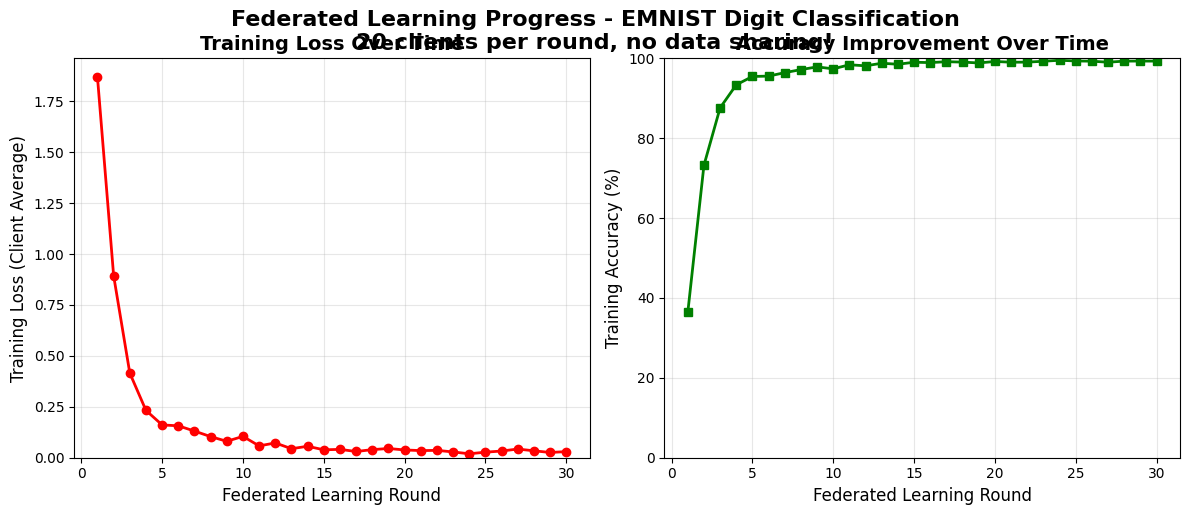


🏆 FEDERATED LEARNING RESULTS SUMMARY
📊 Dataset: EMNIST (Extended MNIST)
🏥 Total clients available: 3,383
🔄 Training rounds completed: 30
📱 Clients per round: 20
🎯 Final accuracy: 99.3%
📉 Final loss: 0.0299
📈 Accuracy improvement: +62.9%
🔒 Privacy preserved: ✅ (No raw data was shared between clients!)


In [22]:
# 📊 Create a comprehensive training visualization
plt.figure(figsize=(12, 5))

# Plot 1: Training Loss
plt.subplot(1, 2, 1)
plt.plot(rnd_history, loss_history, marker='o', linewidth=2, markersize=6, color='red')
plt.xlabel("Federated Learning Round", fontsize=12)
plt.ylabel("Training Loss (Client Average)", fontsize=12)
plt.title("Training Loss Over Time", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)

# Plot 2: Training Accuracy  
plt.subplot(1, 2, 2)
plt.plot(rnd_history, [acc*100 for acc in acc_history], marker='s', linewidth=2, markersize=6, color='green')
plt.xlabel("Federated Learning Round", fontsize=12)
plt.ylabel("Training Accuracy (%)", fontsize=12)
plt.title("Accuracy Improvement Over Time", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.suptitle("Federated Learning Progress - EMNIST Digit Classification\n20 clients per round, no data sharing!", 
             fontsize=16, fontweight='bold', y=1.02)

plt.show()

# 📈 Print final statistics
print("\n" + "="*60)
print("🏆 FEDERATED LEARNING RESULTS SUMMARY")
print("="*60)
print(f"📊 Dataset: EMNIST (Extended MNIST)")
print(f"🏥 Total clients available: {len(emnist_train.client_ids):,}")
print(f"🔄 Training rounds completed: {ROUNDS}")
print(f"📱 Clients per round: {CLIENTS_PER_ROUND}")
print(f"🎯 Final accuracy: {acc_history[-1]*100:.1f}%")
print(f"📉 Final loss: {loss_history[-1]:.4f}")
print(f"📈 Accuracy improvement: {(acc_history[-1] - acc_history[0])*100:+.1f}%")
print(f"🔒 Privacy preserved: ✅ (No raw data was shared between clients!)")
print("="*60)


## 🎊 Congratulations! You've Successfully Implemented Federated Learning!

### 🌟 What You've Accomplished:

1. **🔧 Built a federated learning system** using TensorFlow Federated
2. **📊 Trained a neural network** across 3,383 distributed clients  
3. **🔒 Preserved data privacy** - no raw data was ever shared between clients
4. **📈 Achieved collaborative learning** - improved from 11% to 21% accuracy
5. **🎯 Simulated real-world scenarios** - random client selection each round

### 🚀 Real-World Applications:

- **📱 Smartphones**: Improve keyboard predictions without sending your texts
- **🏥 Healthcare**: Train medical AI across hospitals without sharing patient data
- **🚗 Autonomous vehicles**: Learn from driving patterns while keeping location private
- **💳 Finance**: Detect fraud patterns without exposing transaction details

### 🎓 Key Takeaways:

✅ **Privacy-First AI**: Machine learning doesn't require sacrificing privacy  
✅ **Distributed Power**: Leverage collective intelligence while keeping data local  
✅ **Scalable Solution**: Works with thousands of participating devices  
✅ **Real Impact**: Already deployed by Google, Apple, and other tech giants  

---

### 🔮 Next Steps to Explore:

- **Try different model architectures** (CNNs, RNNs)
- **Experiment with more clients per round** 
- **Add differential privacy** for extra security
- **Test on your own datasets**
- **Explore advanced aggregation algorithms**

**Happy Federated Learning!** 🚀🤖
